# Reverse Engineering Quantum Circuits

When studying the basics of quantum computing we start describing circuits with easy calculations on $2 \times 2$ or $4 \times 4$ matrices, but as soon as we explore the first algorithms we stumble upon oracles that seem to be too complex to be represented like that. But I like matrices: they are like functions that we can study regardless of the input. If we could describe any circuit as a simple combination of matrices, programming circuits would be similar to programming functions. There must be a way. Maybe I found one.

Let's start by importing the needed libraries and defining convenience functions to easily draw circuits and unitary matrices:

In [1]:
from qiskit import QuantumCircuit, execute, Aer
import math

def draw(circuit):
    return circuit.draw(output='mpl')

def unitary(circuit):
    unitary = execute(circuit, Aer.get_backend('unitary_simulator')).result().get_unitary()
    pretty_unitary = ''
    for row in range(len(unitary)):
        pretty_unitary += '|'
        for column in range(len(unitary[row])):
            value = unitary[row][column]
            if math.isclose(value.imag, 0, abs_tol=0.01):
                pretty_value = '{num.real:.0f}'.format(num=value)
            elif math.isclose(value.real, 0, abs_tol=0.01):
                pretty_value = '{num.imag:.0f}i'.format(num=value)
            else:
                pretty_value = '{num.real:.0f}+{num.imag:.0f}i'.format(num=value)
            
            pretty_unitary += pretty_value
            if column < len(unitary[row])-1:
                pretty_unitary += ' '
        pretty_unitary += '|\n'
    print(pretty_unitary)

Since we are going to deal with huge matrices, to make calculations simpler let's also define the following matrices:

$$
\bar{0} = |0\rangle\langle0| =
\begin{bmatrix}
1 & 0\\
0 & 0
\end{bmatrix}
\\[2em]
\bar{1} = |1\rangle\langle1| =
\begin{bmatrix}
0 & 0\\
0 & 1
\end{bmatrix}
$$

With these two atoms of computation we can define other matrices as a combination of them:

$$
I =
\begin{bmatrix}
1 & 0\\
0 & 1
\end{bmatrix}
=
\begin{bmatrix}
1 & 0\\
0 & 0
\end{bmatrix}
+
\begin{bmatrix}
0 & 0\\
0 & 1
\end{bmatrix}
= \bar{0} + \bar{1}
\\[2em]
CX =
\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 0 & 0 & 1\\
0 & 0 & 1 & 0\\
0 & 1 & 0 & 0
\end{bmatrix}
=
\begin{bmatrix}
\bar{0} & \bar{1}\\
\bar{1} & \bar{0}
\end{bmatrix}
=
\begin{bmatrix}
\bar{0} & 0\\
0 & \bar{0}
\end{bmatrix}
+
\begin{bmatrix}
0 & \bar{1}\\
\bar{1} & 0
\end{bmatrix}
= (I \otimes \bar{0}) + (X \otimes \bar{1})
$$

Note how this last sum can be easily interpreted as: _"The second qubit remains the same if the first qubit is $|0\rangle$, but gets flipped if the first qubit is $|1\rangle$."_ That's exactly the description of a CNOT gate!

## $CNOT_{01}$

We know how the CNOT gate works on a two-qubits circuit. We expect no surprises if we add a (completely useless) third qubit.

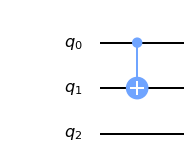

In [2]:
circuit = QuantumCircuit(3)
circuit.cx(0, 1)
draw(circuit)

The corresponding unitary matrix is pretty straightforward, we just need to treat the missing gate in the third qubit as an Identity matrix. Let's turn it into a combination of smaller matrices:

$$
I \otimes CX =
\begin{bmatrix}
CX & 0\\
0 & CX
\end{bmatrix}
=
\begin{bmatrix}
\bar{0} & \bar{1} & 0 & 0\\
\bar{1} & \bar{0} & 0 & 0\\
0 & 0 & \bar{0} & \bar{1}\\
0 & 0 & \bar{1} & \bar{0}
\end{bmatrix}
=
\begin{bmatrix}
\bar{0} & 0 & 0 & 0\\
0 & \bar{0} & 0 & 0\\
0 & 0 & \bar{0} & 0\\
0 & 0 & 0 & \bar{0}
\end{bmatrix}
+
\begin{bmatrix}
0 & \bar{1} & 0 & 0\\
\bar{1} & 0 & 0 & 0\\
0 & 0 & 0 & \bar{1}\\
0 & 0 & \bar{1} & 0
\end{bmatrix}
=
(I \oplus I \oplus \bar{0}) + (I \oplus X \oplus \bar{1})
$$

Which we can interpret as: _"The second qubit remains the same if the first one is equal to $|0\rangle$, but gets flipped when it's $|1\rangle$. The third qubit is irrelevant."_ This is exactly the same as describing a CNOT gate between the first two qubits, with an Identity matrix on the third!

In [3]:
unitary(circuit)

|1 0 0 0 0 0 0 0|
|0 0 0 1 0 0 0 0|
|0 0 1 0 0 0 0 0|
|0 1 0 0 0 0 0 0|
|0 0 0 0 1 0 0 0|
|0 0 0 0 0 0 0 1|
|0 0 0 0 0 0 1 0|
|0 0 0 0 0 1 0 0|



## $\text{CNOT}_{12}$

Nothing much changes if the third qubit is instead positioned on top, to be the first one.

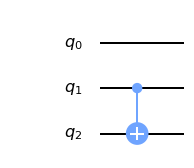

In [4]:
circuit = QuantumCircuit(3)
circuit.cx(1, 2)
draw(circuit)

Here we can also easily calculate the resulting unitary matrix and split it into a combination of smaller matrices, just like before:

$$
CX \otimes I =
\begin{bmatrix}
I & 0 & 0 & 0\\
0 & 0 & 0 & I\\
0 & 0 & I & 0\\
0 & I & 0 & 0
\end{bmatrix}
= \begin{bmatrix}
I & 0 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & I & 0\\
0 & 0 & 0 & 0
\end{bmatrix}
+
\begin{bmatrix}
0 & 0 & 0 & 0\\
0 & 0 & 0 & I\\
0 & 0 & 0 & 0\\
0 & I & 0 & 0
\end{bmatrix}
= (I \otimes \bar{0} \otimes I) + (X \otimes \bar{1} \otimes I)
$$

The interpretation is pretty similar to the previous, only the order changes: _"The third qubit remains the same if the second qubit is equal to $|0\rangle$, but gets flipped if the second qubit is $|1\rangle$. The first qubit is irrelevant."_

In [5]:
unitary(circuit)

|1 0 0 0 0 0 0 0|
|0 1 0 0 0 0 0 0|
|0 0 0 0 0 0 1 0|
|0 0 0 0 0 0 0 1|
|0 0 0 0 1 0 0 0|
|0 0 0 0 0 1 0 0|
|0 0 1 0 0 0 0 0|
|0 0 0 1 0 0 0 0|



## $\text{CNOT}_{02}$

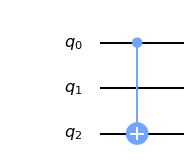

In [6]:
circuit = QuantumCircuit(3)
circuit.cx(0, 2)
draw(circuit)

Here it gets trickier, because the $I$ is between the control and the target of the CNOT. I have no idea how to build this matrix, so I'll leave this calculation to Qiskit:

In [7]:
unitary(circuit)

|1 0 0 0 0 0 0 0|
|0 0 0 0 0 1 0 0|
|0 0 1 0 0 0 0 0|
|0 0 0 0 0 0 0 1|
|0 0 0 0 1 0 0 0|
|0 1 0 0 0 0 0 0|
|0 0 0 0 0 0 1 0|
|0 0 0 1 0 0 0 0|



We can see this matrix as:

$$
\begin{bmatrix}
\bar{0} & 0 & \bar{1} & 0\\
0 & \bar{0} & 0 & \bar{1}\\
\bar{1} & 0 & \bar{0} & 0\\
0 & \bar{1} & 0 & \bar{0}
\end{bmatrix}
=
\begin{bmatrix}
\bar{0} & 0 & 0 & 0\\
0 & \bar{0} & 0 & 0\\
0 & 0 & \bar{0} & 0\\
0 & 0 & 0 & \bar{0}
\end{bmatrix}
+
\begin{bmatrix}
0 & 0 & \bar{1} & 0\\
0 & 0 & 0 & \bar{1}\\
\bar{1} & 0 & 0 & 0\\
0 & \bar{1} & 0 & 0
\end{bmatrix}
=
(I \otimes I \otimes \bar{0}) + (X \otimes I \otimes \bar{1})
$$

Which could be interpreted as: _"The third qubit remains the same if the first qubit is equal to $|0\rangle$, but gets flipped when the first qubit is $|1\rangle$. The second qubit is irrelevant."_ This is exactly like the previous two gates, but again in a different order!

## $\text{CNOT}_{02} + \text{CNOT}_{12}$

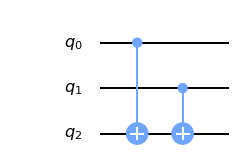

In [8]:
circuit = QuantumCircuit(3)
circuit.cx(0, 2)
circuit.cx(1, 2)
draw(circuit)

This circuit looks even tougher. Let's reverse-engineer it by having a look at the computed unitary matrix:

In [9]:
unitary(circuit)

|1 0 0 0 0 0 0 0|
|0 0 0 0 0 1 0 0|
|0 0 0 0 0 0 1 0|
|0 0 0 1 0 0 0 0|
|0 0 0 0 1 0 0 0|
|0 1 0 0 0 0 0 0|
|0 0 1 0 0 0 0 0|
|0 0 0 0 0 0 0 1|



The matrix looks like the following:

$$
\begin{bmatrix}
\bar{0} & 0 & \bar{1} & 0\\
0 & \bar{1} & 0 & \bar{0}\\
\bar{1} & 0 & \bar{0} & 0\\
0 & \bar{0} & 0 & \bar{1}
\end{bmatrix}
=
\begin{bmatrix}
\bar{0} & 0 & 0 & 0\\
0 & 0 & 0 & \bar{0}\\
0 & 0 & \bar{0} & 0\\
0 & \bar{0} & 0 & 0
\end{bmatrix}
+
\begin{bmatrix}
0 & 0 & \bar{1} & 0\\
0 & \bar{1} & 0 & 0\\
\bar{1} & 0 & 0 & 0\\
0 & 0 & 0 & \bar{1}
\end{bmatrix}\\
= (CX \otimes \bar{0}) + (X \otimes I \otimes I) \cdot (CX \otimes \bar{1})
$$

Let's go a little further by expanding the CNOT gates:

$$
= (I \otimes \bar{0} \otimes \bar{0} + X \otimes \bar{1} \otimes \bar{0}) + (X \otimes I \otimes I) \cdot (I \otimes \bar{0} \otimes \bar{1} + X \otimes \bar{1} \otimes \bar{1})
$$

And now, applying the product:

$$
= (I \otimes \bar{0} \otimes \bar{0}) + (X \otimes \bar{1} \otimes \bar{0}) + (X \otimes \bar{0} \otimes \bar{1}) + (I \otimes \bar{1} \otimes \bar{1})
$$

Which could be interpreted as: _"The third qubit is flipped if only one of the other two is equal to $|1\rangle$. In any other case it stays the same."_ It looks like a XOR which keeps the inputs in the first two qubits and holds the output in the third one. Now it makes sense!

Note that the result we found suggests to split the matrix in the following way, which is equivalent:

$$
\begin{bmatrix}
\bar{0} & 0 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & \bar{0} & 0\\
0 & 0 & 0 & 0
\end{bmatrix}
+
\begin{bmatrix}
0 & 0 & 0 & 0\\
0 & 0 & 0 & \bar{0}\\
0 & 0 & 0 & 0\\
0 & \bar{0} & 0 & 0
\end{bmatrix}
+
\begin{bmatrix}
0 & 0 & \bar{1} & 0\\
0 & 0 & 0 & 0\\
\bar{1} & 0 & 0 & 0\\
0 & 0 & 0 & 0
\end{bmatrix}
+
\begin{bmatrix}
0 & 0 & 0 & 0\\
0 & \bar{1} & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & \bar{1}
\end{bmatrix}
=
\begin{bmatrix}
\bar{0} & 0 & \bar{1} & 0\\
0 & \bar{1} & 0 & \bar{0}\\
\bar{1} & 0 & \bar{0} & 0\\
0 & \bar{0} & 0 & \bar{1}
\end{bmatrix}
$$

## Simon's Oracle

Now that we know how to reverse-engineer a unitary matrix into a circuit, is it also possible to "forward-engineer" a circuit into a matrix? Let's try it out with the oracle described in [Simon's algorithm](https://qiskit.org/textbook/ch-algorithms/simon.html):

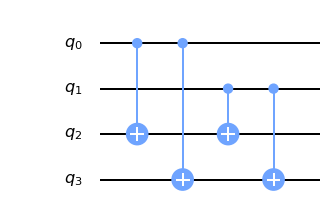

In [10]:
circuit = QuantumCircuit(4)
circuit.cx(0, 2)
circuit.cx(0, 3)
circuit.cx(1, 2)
circuit.cx(1, 3)
draw(circuit)

Let's describe this circuit:

1. _"The third qubit is flipped if the first one or the second one is $|1\rangle$"_
2. _"The fourth qubit is flipped if the first one or the second one is $|1\rangle$"_
3. _"Any other case doesn't change the state of the third or fourth qubit"_

Now, in maths:

$$
\text{1. } (I \otimes X \otimes \bar{0} \otimes \bar{1}) + (I \otimes X \otimes \bar{1} \otimes \bar{0})\\
\text{2. } (X \otimes I \otimes \bar{0} \otimes \bar{1}) + (X \otimes I \otimes \bar{1} \otimes \bar{0})\\
\text{3. } (I \otimes I \otimes \bar{0} \otimes \bar{0}) + (I \otimes I \otimes \bar{1} \otimes \bar{1})
$$

We can simplify even further by combining 1. and 2. together, since both target qubits are flipped at the same time:

$$
\text{1+2. } (X \otimes X \otimes \bar{0} \otimes \bar{1}) + (X \otimes X \otimes \bar{1} \otimes \bar{0})\\
\text{3. } (I \otimes I \otimes \bar{0} \otimes \bar{0}) + (I \otimes I \otimes \bar{1} \otimes \bar{1})
$$

If the description is correct, the resulting matrix should be:

$$
\begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 & \bar{1} & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & \bar{0}\\
0 & 0 & 0 & 0 & \bar{1} & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & \bar{0} & 0 & 0\\
0 & 0 & \bar{1} & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & \bar{0} & 0 & 0 & 0 & 0\\
\bar{1} & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & \bar{0} & 0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix}
+
\begin{bmatrix}
\bar{0} & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & \bar{1} & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & \bar{0} & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & \bar{1} & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & \bar{0} & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & \bar{1} & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & \bar{0} & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & \bar{1}
\end{bmatrix}
=
\begin{bmatrix}
\bar{0} & 0 & 0 & 0 & 0 & 0 & \bar{1} & 0\\
0 & \bar{1} & 0 & 0 & 0 & 0 & 0 & \bar{0}\\
0 & 0 & \bar{0} & 0 & \bar{1} & 0 & 0 & 0\\
0 & 0 & 0 & \bar{1} & 0 & \bar{0} & 0 & 0\\
0 & 0 & \bar{1} & 0 & \bar{0} & 0 & 0 & 0\\
0 & 0 & 0 & \bar{0} & 0 & \bar{1} & 0 & 0\\
\bar{1} & 0 & 0 & 0 & 0 & 0 & \bar{0} & 0\\
0 & \bar{0} & 0 & 0 & 0 & 0 & 0 & \bar{1}
\end{bmatrix}
$$

Will it work?

In [11]:
unitary(circuit)

|1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0|
|0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0|
|0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0|
|0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0|
|0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0|
|0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0|
|0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0|
|0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0|
|0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0|
|0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0|
|0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0|
|0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0|
|0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0|
|0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0|
|0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0|
|0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1|



It does! Now we are able to build unitary matrices for our oracles, using just our common sense!

In [12]:
# IceOnFire